In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Pré-Processamento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

# Modelos e métricas
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, root_mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

sns.set_style("darkgrid")

In [3]:
dados_dict = pd.read_csv('../data/external/dictionary.csv')
dados = pd.read_csv('../data/raw/simplified_coffee.csv')

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 953 non-null    object 
 1   roaster              953 non-null    object 
 2   roast                949 non-null    object 
 3   loc_country          953 non-null    object 
 4   origin               953 non-null    object 
 5   100g_USD             953 non-null    float64
 6   rating               953 non-null    int64  
 7   mes                  953 non-null    object 
 8   ano                  953 non-null    int64  
 9   preco_qualidade      953 non-null    float64
 10  idade_cafe           953 non-null    int64  
 11  avaliacao_rating     953 non-null    object 
 12  classificacao_preco  953 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 96.9+ KB


In [5]:
dados

,name,roaster,roast,loc_country,origin,100g_USD,rating,mes,ano,preco_qualidade,idade_cafe,avaliacao_rating,classificacao_preco
0,Ethiopia Shakiso Mormora,Revel Coffee,Medium-Light,United States,Ethiopia,4.70,92,November,2017,0.051087,7,High,barato
1,Ethiopia Suke Quto,Roast House,Medium-Light,United States,Ethiopia,4.19,92,November,2017,0.045543,7,High,barato
2,Ethiopia Gedeb Halo Beriti,Big Creek Coffee Roasters,Medium,United States,Ethiopia,4.85,94,November,2017,0.051596,7,High,barato
3,Ethiopia Kayon Mountain,Red Rooster Coffee Roaster,Light,United States,Ethiopia,5.14,93,November,2017,0.055269,7,High,barato
4,Ethiopia Gelgelu Natural Organic,Willoughby's Coffee & Tea,Medium-Light,United States,Ethiopia,3.97,93,November,2017,0.042688,7,High,barato
...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,Finca Patzibir,El Gran Cafe,Medium-Light,Guatemala,Guatemala,4.70,92,November,2022,0.051087,2,High,barato
949,Proyecto Aurora,El Gran Cafe,Medium-Light,Guatemala,Guatemala,2.94,93,November,2022,0.031613,2,High,barato
950,Finca El Potrero,El Gran Cafe,Medium-Light,Guatemala,Guatemala,2.94,93,November,2022,0.031613,2,High,barato
951,Chacayá Santiago Atitlán,El Gran Cafe,Medium-Light,Guatemala,Guatemala,4.70,93,November,2022,0.050538,2,High,barato


In [6]:
dados = dados.rename(columns= {"100g_USD": "target"})

In [7]:
dados['rating'].unique()

array([92, 94, 93, 90, 91, 95, 89, 96, 97], dtype=int64)

Separação das variáveis numéricas e categóricas 

In [8]:
categorical_var = [col for col in dados.columns if dados[col].dtype == 'object']
numerical_var = [col for col in dados.columns if dados[col].dtype != 'object' and col != 'target']

In [9]:
categorical_var

['name',
 'roaster',
 'roast',
 'loc_country',
 'origin',
 'mes',
 'avaliacao_rating',
 'classificacao_preco']

In [10]:
X = dados.drop("target", axis = 1)
y = dados["target"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((762, 12), (191, 12), (762,), (191,))

### Construção do Pipeline, e os transformadores das colunas categóricas e númericas

In [13]:
# transformador numérico
numeric_transform = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

#Transformador categórico

categoric_transform = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy= 'most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transform, numerical_var),
        ('cat', categoric_transform, categorical_var)
    ]
)

In [14]:
import numpy as np
import scipy as sp

x = np.array([[0, 1,0, 0], [1, 0, 0, 0],[0,0,1, 0]])

sp.spatial.distance.pdist(x)


array([1.41421356, 1.41421356, 1.41421356])

### Treinamento dos Modelos

In [15]:
# Modelos que iremos usar
modelos = {
    "XGBRegressor": XGBRegressor(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "DummyRegressor" : DummyRegressor()
}

In [16]:

def rmse_scorer(y_true, y_pred): #está sendo usado para calcular essa métrica durante a validação cruzada que é usada utilizando os dados de treino
    return np.sqrt(mean_squared_error(y_true, y_pred))

def fit_and_pontuacao(modelos, X_train, X_test, y_train, y_test):
    modelos_pontuacao_treino = {}
    modelos_pontuacao_teste = {}

    for name, modelo in modelos.items():

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', modelo)
        ])

        pipeline.fit(X_train, y_train)

        # Usando validação cruzada para comparação utilizando os dados de treino
        rmse_cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=make_scorer(rmse_scorer))
        mae_cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

        modelos_pontuacao_treino[name] = {
            "rmse_csv_scores": np.mean(np.abs(rmse_cv_scores)),
            "mae_cv_scores": np.mean(np.abs(mae_cv_scores))
        }

        # Utilizando os dados de teste
        y_pred = pipeline.predict(X_test)

        rmse_teste = round(np.sqrt(mean_absolute_error(y_test, y_pred)),3)
        mae_teste = round(mean_absolute_error(y_test, y_pred), 3)

        modelos_pontuacao_teste[name] = {
            "rmse": rmse_teste,
            "mae": mae_teste
        }

    return modelos_pontuacao_treino, modelos_pontuacao_teste


In [17]:
model_pontuacao_treino, model_pontuacao_teste = fit_and_pontuacao(modelos, X_train, X_test, y_train, y_test)

print('---- Pontuação no Treinamento ----')
print(model_pontuacao_treino)
print('\n')

print('---- Pontuação no Teste ----')
print(model_pontuacao_teste)

---- Pontuação no Treinamento ----
{'XGBRegressor': {'rmse_csv_scores': 0.06402328530732926, 'mae_cv_scores': 0.035207508543491514}, 'KNN': {'rmse_csv_scores': 0.47781559966435616, 'mae_cv_scores': 0.35176721706226355}, 'SVR': {'rmse_csv_scores': 0.26045208985333484, 'mae_cv_scores': 0.1941547838076771}, 'DummyRegressor': {'rmse_csv_scores': 1.6420057969177115, 'mae_cv_scores': 1.2641407902989759}}


---- Pontuação no Teste ----
{'XGBRegressor': {'rmse': 0.192, 'mae': 0.037}, 'KNN': {'rmse': 0.601, 'mae': 0.362}, 'SVR': {'rmse': 0.45, 'mae': 0.202}, 'DummyRegressor': {'rmse': 1.128, 'mae': 1.273}}


In [18]:
modelos_comparacao_treino = pd.DataFrame(model_pontuacao_treino).T
modelos_comparacao_treino.columns = ["RMSE", "MAE"]

modelos_comparacao_teste_antes = pd.DataFrame(model_pontuacao_teste).T
modelos_comparacao_teste_antes.columns = ["RMSE", "MAE"]

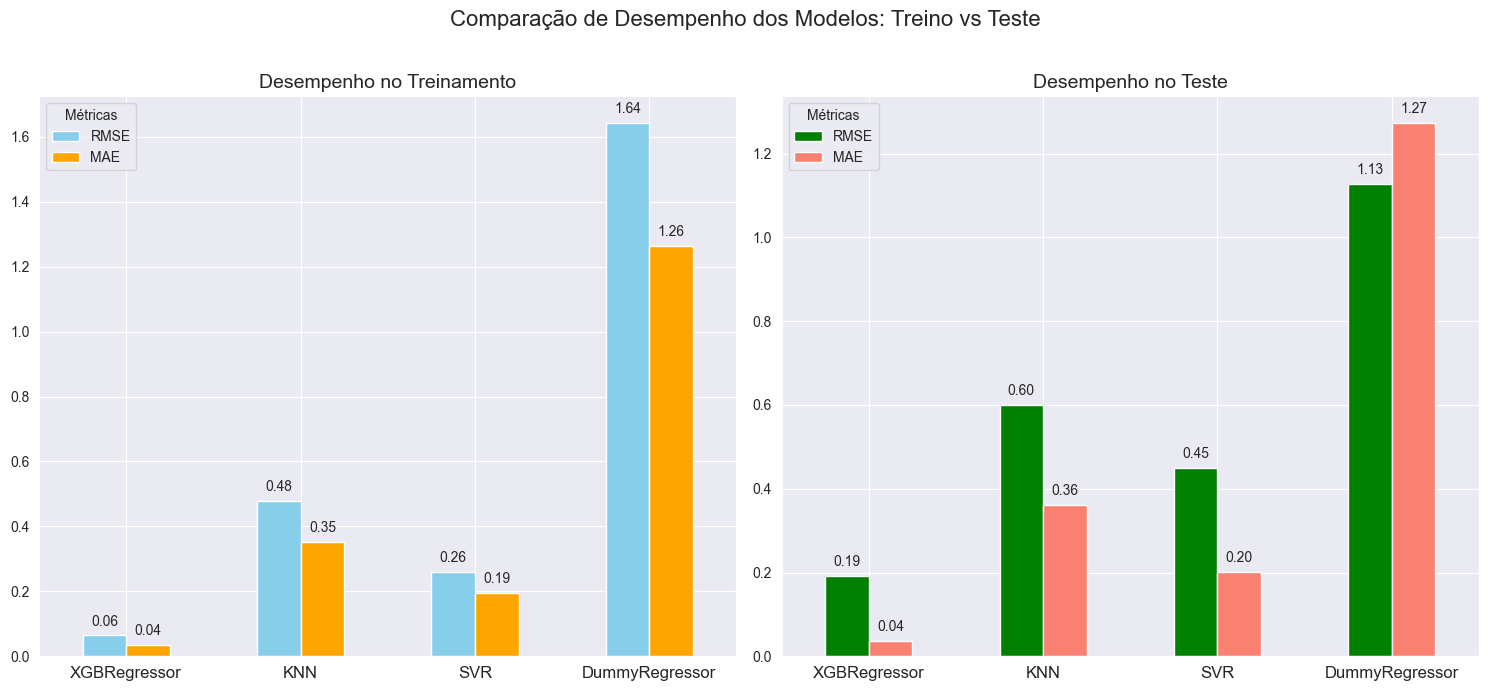

In [31]:
import matplotlib.pyplot as plt

# Exemplo de comparação de métricas
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Gráfico 1: Modelos Comparação Geral (Treino)
modelos_comparacao_treino.plot.bar(ax=ax1, legend=True, color=["skyblue", "orange"])
ax1.set_title("Desempenho no Treinamento", fontsize=14)
ax1.set_xlabel("", rotation=0, fontsize=12)
ax1.set_ylabel("", fontsize=12)
ax1.legend(title="Métricas", fontsize=10)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha="center", fontsize=12)

for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom', fontsize=10)


# Gráfico 2: Modelos Comparação Pós (Teste)
modelos_comparacao_teste_antes.plot.bar(ax=ax2, legend=True, color=["green", "salmon"])
ax2.set_title("Desempenho no Teste", fontsize=14)
ax2.set_xlabel("", rotation=0, fontsize=12)
ax2.set_ylabel("", fontsize=12)
ax2.legend(title="Métricas", fontsize=10)


for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom', fontsize=10)


ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha="center", fontsize=12)

plt.suptitle("Comparação de Desempenho dos Modelos: Treino vs Teste", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta o layout para não sobrepor os títulos

plt.show()

### Raiz do Erro Médio Quadrático (RMSE - ROOT Mean Squared Error)

A RMSE é a raiz quadrada do MSE, ela mede o erro em uma escala comparável à dos valores reais, tornando a interpretação mais intuitiva

    * Apresenta as unidades originais das variáveis preditas
    * Pernaliza grandes erros mais que o MAE, mas menos que o MSE.

### Erro Médio Absoluto (MAE - Mean Absolute Error)

O Mae mede a média das diferenças absolutas entre os valores preditos e os valores reais. É uma métrica simples que avalia o quão longe, em médias, as previsões estão dos valores reais.

    * Valores menores indicam melhor desempenho.

### Utilizando o Otimizador de Hiperparâmetros para todos os modelos

Iremos utilizar a Otimização RandomizedSearchCV

In [20]:
param_space_XGB = {
    'regressor__n_estimators': [100, 500, 900, 1100, 1500],
    'regressor__max_depth': [2, 3, 5, 10, 15],
    'regressor__learning_rate': [0.05, 0.1, 0.15, 0.20],
    'regressor__min_child_weight': [1, 2, 3, 4]

}

param_space_SVR = {
    'regressor__C': [0.1, 1, 10, 100, 1000],
    'regressor__epsilon': [0.01, 0.1, 1, 10],
    'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'regressor__degree': [2, 3, 4],
    'regressor__gamma': ['scale', 'auto']
}

param_space_KNN = {
    'regressor__n_neighbors': [3, 5],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__metric': ['euclidean', 'manhattan', 'minkowski']

}

param_space_DUMM = {
    'regressor__strategy': ['mean', 'median',  'constant'],
    'regressor__constant': [0, 1, 10]
}

lista_param = {
    "XGB": param_space_XGB,
    "SVR": param_space_SVR,
    "KNN": param_space_KNN,
    "Comparativo": param_space_DUMM
}

### Por padrão, O BayesSearchCV usará R - quadrado para problemas de regressão

Essa medida representa a proporção da variabilidade dos dados de saída que é explicada pelo modelo. Ela indica o quão bem as previsões do modelo correspodem aos dados reais

* R - quadrado alto (próximo de 1): O modelo tem um bom ajuste aos dados
* R - quadrado (próximo de 0): O modelo não explica bem a variabilidade dos dados
* R -quadrado = 0: O modelo é tão bom quanto usar a média dos valores

In [21]:
def init_optimization(lista_param, X_train, y_train):
    best_params = {}
    for name, hiper in lista_param.items():

        if "XGB" in name:
            estimator = XGBRegressor()

        elif "SVR" in name:
            estimator = SVR()

        elif "KNN" in name:
            estimator = KNeighborsRegressor()

        elif "Comparativo" in name:
            estimator = DummyRegressor()

        model_pipeline = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('regressor', estimator)
            ]
        )

        opt = RandomizedSearchCV(estimator=model_pipeline, param_distributions=hiper, n_iter=min(20, len(hiper)), scoring='neg_root_mean_squared_error', random_state= 42, cv = 10)

        opt.fit(X_train, y_train)

        print(f"Os melhores parâmetros para o modelo {name}: {opt.best_params_}")
        print(f"Melhor pontuação: {opt.best_score_}\n")

def modeling_test(modelos_pos_opt, X_train, y_train,  X_test, y_test):
    modelos_otimizados = {}

    for name, model in modelos_pos_opt.items():

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)

        # Calcula as métricas no conjunto de teste
        rmse_teste = np.sqrt(mean_absolute_error(y_test, y_pred))
        mae_teste = mean_absolute_error(y_test, y_pred)


        modelos_otimizados[name] = {
            "RMSE": round(rmse_teste, 3),
            "MAE": round(mae_teste, 3)
        }

    return modelos_otimizados

In [22]:
#Iniciar a otimização
best_params = init_optimization(lista_param, X_train, y_train)

Os melhores parâmetros para o modelo XGB: {'regressor__n_estimators': 1100, 'regressor__min_child_weight': 2, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.2}
Melhor pontuação: -0.04681873820449803

Os melhores parâmetros para o modelo SVR: {'regressor__kernel': 'sigmoid', 'regressor__gamma': 'auto', 'regressor__epsilon': 0.1, 'regressor__degree': 2, 'regressor__C': 1000}
Melhor pontuação: -0.06516242689319127

Os melhores parâmetros para o modelo KNN: {'regressor__weights': 'uniform', 'regressor__n_neighbors': 5, 'regressor__metric': 'minkowski'}
Melhor pontuação: -0.4655589216041628

Os melhores parâmetros para o modelo Comparativo: {'regressor__strategy': 'median', 'regressor__constant': 10}
Melhor pontuação: -1.6721887888400464



In [23]:
#Modelos para rodar depois que rodar a funcao de otimização para poder pegar os melhores parâmetros
modelos_pos_opt = {
    "XGBRegressor": XGBRegressor(n_estimators =  1100, min_child_weight = 2, max_depth =  5, learning_rate= 0.2),
    "SVR": SVR(kernel = 'sigmoid', gamma = 'auto', epsilon= 0.1, degree = 2, C = 1000),
    "KNN": KNeighborsRegressor(weights = 'uniform', n_neighbors = 5, metric = 'minkowski'),
    "DummyRegressor": DummyRegressor(strategy= 'median', constant= 10)
}

In [24]:
modelos_otimizados = modeling_test(modelos_pos_opt, X_train, y_train,  X_test, y_test)
modelos_otimizados

{'XGBRegressor': {'RMSE': 0.181, 'MAE': 0.033},
 'SVR': {'RMSE': 0.233, 'MAE': 0.054},
 'KNN': {'RMSE': 0.601, 'MAE': 0.362},
 'DummyRegressor': {'RMSE': 1.128, 'MAE': 1.273}}

In [25]:
modelos_otimizados = pd.DataFrame(modelos_otimizados).T
modelos_otimizados.columns = ["RMSE", "MAE"]

### Comparativo de resultado de métricas dos moodelos que foram otimizados e os que não foram

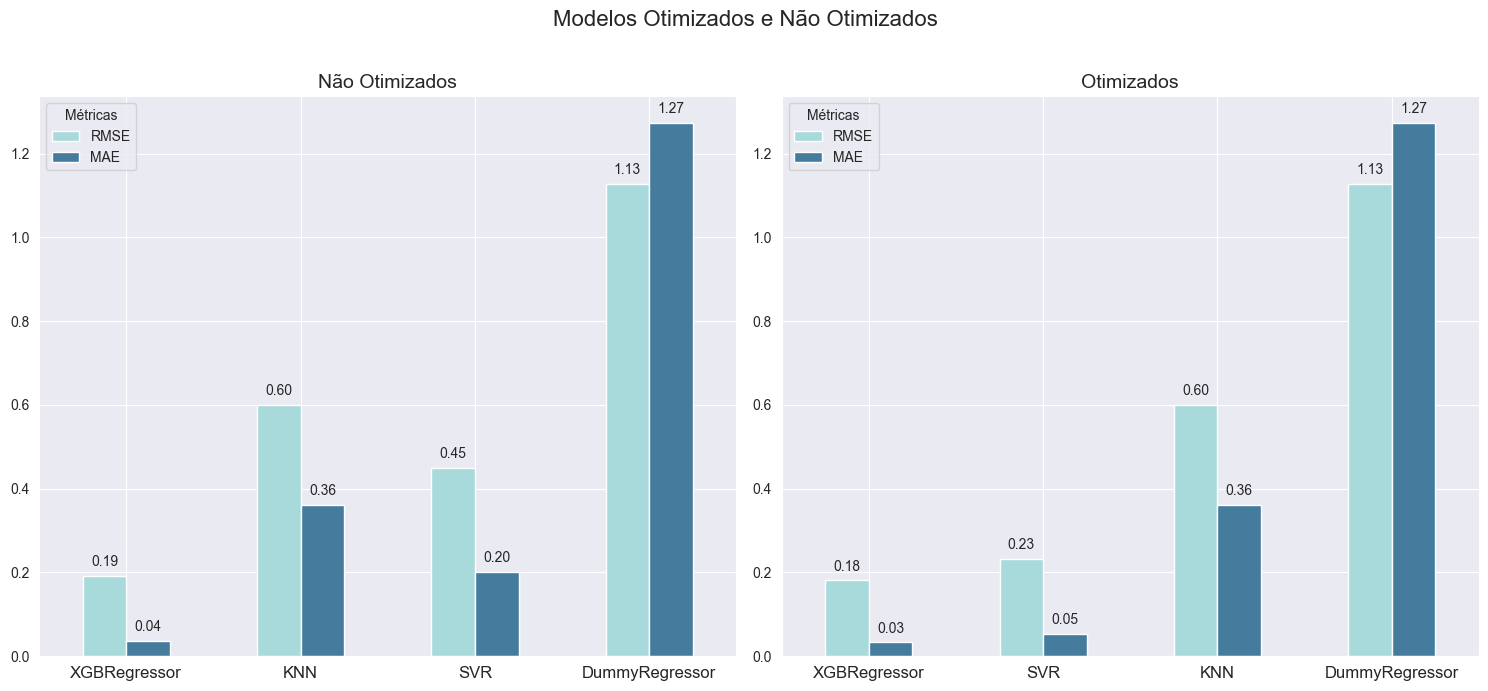

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Gráfico 1: Modelos Comparação Geral
modelos_comparacao_teste_antes.plot.bar(ax=ax1, legend=True, color=["#A8DADC", "#457B9D"])
ax1.set_title("Não Otimizados", fontsize=14)
ax1.set_xlabel("",rotation = 1, fontsize=12)
ax1.set_ylabel("", fontsize=12)
ax1.legend(title="Métricas", fontsize=10)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha="center", fontsize=12)  #deixar o nome dos modelos na horizontal

for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom', fontsize=10)


# Gráfico 2: Modelos Comparação Pós
modelos_otimizados.plot.bar(ax=ax2, legend=True, color=["#A8DADC", "#457B9D"])
ax2.set_title("Otimizados", fontsize=14)
ax2.set_xlabel("", rotation = 180, fontsize=12)
ax2.set_ylabel("", fontsize=12)
ax2.legend(title="Métricas", fontsize=10)

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha="center", fontsize=12)

for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom', fontsize=10)

plt.suptitle("Modelos Otimizados e Não Otimizados", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("modelo_otimizado_X_N_otimizado.png")

plt.show()

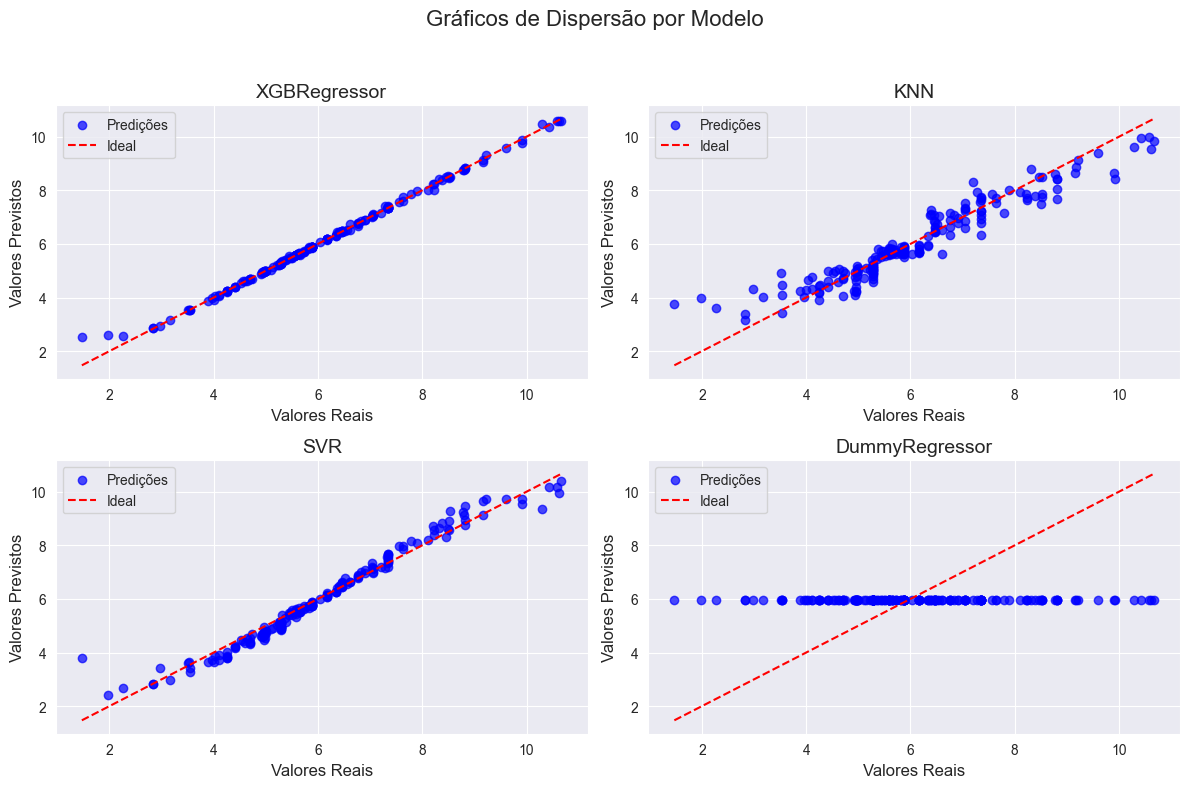

In [ ]:
y_preds = {}

for name, modelo in modelos.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', modelo)
    ])
    pipeline.fit(X_train, y_train)
    y_preds[name] = pipeline.predict(X_test)

y_min = min(y_test.min(), *(pred.min() for pred in y_preds.values()))
y_max = max(y_test.max(), *(pred.max() for pred in y_preds.values()))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 para 4 modelos
axs = axs.flatten()

for i, (name, y_pred) in enumerate(y_preds.items()):
    axs[i].scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predições")
    axs[i].plot([y_min, y_max], [y_min, y_max], color="red", linestyle="--", label="Ideal")
    axs[i].set_xlim(y_min - 0.5, y_max + 0.5)  # Adiciona uma margem
    axs[i].set_ylim(y_min - 0.5, y_max + 0.5)  # Adiciona uma margem
    axs[i].set_title(f"{name}", fontsize=14)
    axs[i].set_xlabel("Valores Reais", fontsize=12)
    axs[i].set_ylabel("Valores Previstos", fontsize=12)
    axs[i].legend()


plt.suptitle("Gráficos de Dispersão por Modelo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("modelo_grafico_dispersao.png")
plt.show()
